
### Install AutoKeras
Uncomment the following code if Autokeras is not intalled yet

In [ ]:
!pip3 install autokeras

### Getting the IMDB faces dataset 

In [2]:
# Download and extract the data if it doesn't exist yet
!wget -nc https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
!tar --no-overwrite-dir -xf imdb_crop.tar

--2021-01-18 19:37:22--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  19.5MB/s    in 5m 44s  

2021-01-18 19:43:07 (19.4 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



In [3]:
import os
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from scipy.io import loadmat
import autokeras as ak



### Data preprocessing
Helper functions to process the raw data.

For training we will need the age, but this is not stored as meta-information 
and has to be calculated. We can obtain it by subtracting from the date when the photo was taken the date of birth of each celebrity. 

But the date of birth (dob) is stored as a Matlab serial number, so we will load the .mat file into a format and convert the Matlab serial number to date so we can extract the age. 


In [4]:
"""
This functions are adapted from [notebook](https://gist.github.com/mapmeld/98d1e9839f2d1f9c4ee197953661ed07)
"""
def _datenum_to_datetime(datenum):
    """
    Convert Matlab datenum to datetime because the date of birth (dob) is stored as a Matlab serial number,
    so we have to convert this Matlab serial number to datetime so we can extract the age.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    try:
        return (
            datetime.fromordinal(int(datenum))
            + timedelta(days=int(days))
            + timedelta(hours=int(hours))
            + timedelta(minutes=int(minutes))
            + timedelta(seconds=round(seconds))
            - timedelta(days=366)
        )
    except:
        return _datenum_to_datetime(700000)

def imdb_meta_to_df(matlab_filename):
    """
    Convert IMDB MatLab file to Pandas DataFrame
    """
    mat_dict = loadmat(matlab_filename)
    mat_data = mat_dict["imdb"]
    mat_dtype = mat_data.dtype
    ndata = {n: mat_data[n][0, 0] for n in mat_dtype.names}
    columns = [n for n, v in ndata.items()]
    rows = []
    for col in range(0, 10):
        values = list(ndata.items())[col]
        for num, val in enumerate(values[1][0], start=0):
            if col == 0:
                rows.append([])
            if num > 0:
                if columns[col] == "dob":
                    rows[num].append(_datenum_to_datetime(int(val)))
                elif columns[col] == "photo_taken":
                    rows[num].append(datetime(year=int(val), month=6, day=30))
                else:
                    rows[num].append(val)
    dt = map(lambda row: np.array(row), np.array(rows[1:]))
    df = pd.DataFrame(data=dt, index=range(0, len(rows) - 1), columns=columns)
    # Calculate age at time photo was taken
    df["age"] = (df["photo_taken"] - df["dob"]).astype("int") / 31558102e9
    return df


def normalize_dataset(df_train_set):
    """
    Return a tuple of normalized images (resized to 128x128 and converted to grayscale) and ages converted to integers
    """
    images = []
    for img_path in train_set["full_path"]:
        img = (
            Image.open("imdb_crop/" + img_path[0])
            .resize((128, 128))
            .convert("L")
        )
        images.append(np.asarray(img, dtype="int32"))

    image_inputs = np.array(images)

    ages = train_set["age"].astype("int").to_numpy()
    return image_inputs, ages

### Creating the data sets

In [5]:
df = imdb_meta_to_df("imdb_crop/imdb.mat")

train_set = df.sample(20000)
train_imgs, train_ages = normalize_dataset(train_set)
test_set = df.sample(2000)
test_imgs, test_ages = normalize_dataset(test_set)
train_imgs.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(20000, 128, 128)

### Showing some samples

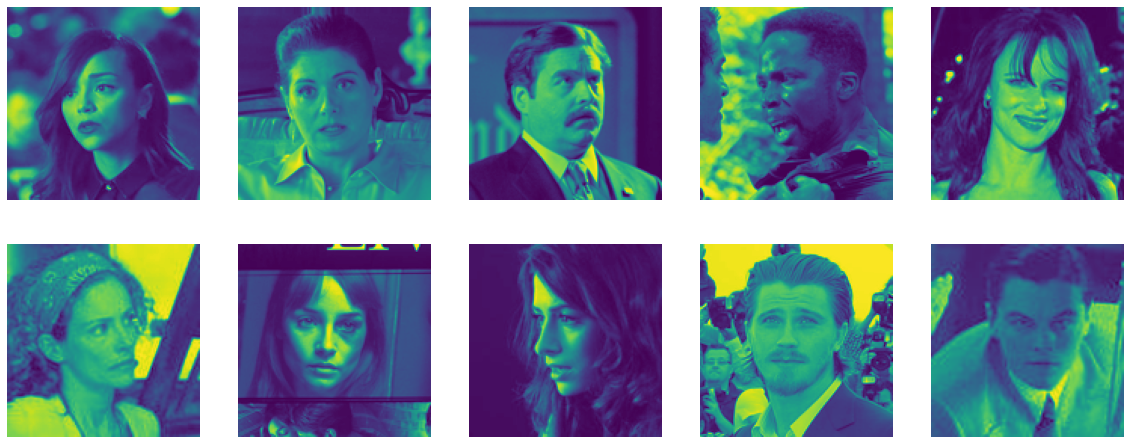

In [6]:
# Show samples
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[20,8])
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_axis_off()
    img = test_imgs[i]
    ax.imshow(img)
plt.show()

### Creating and training the models

In [ ]:
# Initialize the image regressor
reg = ak.ImageRegressor(max_trials=10)  # AutoKeras tries 10 different models.

# Find the best model for the given training data
reg.fit(train_imgs, train_ages, epochs=10)

### Evaluating the best model

In [ ]:
# Evaluate the chosen model with testing data
print(reg.evaluate(test_imgs, test_ages))


625/625 [==============================] - 10s 13ms/step - loss: 111.2134 - mean_squared_error: 111.2134
[111.21337127685547, 111.21337127685547]


### Improving the model search

If we need more precision in less time, we can fine-tune our model using an advanced Autokeras feature that allows you to customize your search space. 

Using AutoModel with ImageBlock instead of ImageRegressor, we can create high-level configurations, such as block_type for the type of neural network to look for, we can also perform data normalization or perform data augmentation. 

If we have knowledge of deep learning and have faced this problem before, we can design a suitable architecture as a EfficientNet-based image regressor, for instance, which is a deep residual learning architecture for image recognition. https://keras.io/api/applications/efficientnet/ 

In [ ]:
from tensorflow.keras import callbacks as tf_callbacks
cbs = [
    tf_callbacks.EarlyStopping(patience=3, monitor='val_mean_squared_error', verbose=1),
]

input_node = ak.ImageInput() 
output_node = ak.Normalization()(input_node) 
output_node = ak.ImageAugmentation()(output_node) 
output_node = ak.ImageBlock(block_type="efficient")(input_node) 
output_node = ak.RegressionHead()(output_node) 
automodel = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=20) 
automodel.fit(train_imgs, train_ages, callbacks = cbs) 


Trial 20 Complete [00h 01m 52s]
val_loss: 164.372314453125

Best val_loss So Far: 141.72084045410156
Total elapsed time: 03h 01m 05s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
625/625 [==============================] - 111s 160ms/step - loss: 408.0833 - mean_squared_error: 408.0833
Epoch 2/2
625/625 [==============================] - 100s 160ms/step - loss: 138.0503 - mean_squared_error: 138.0503
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [ ]:
# Evaluate the chosen model with testing data
print(automodel.evaluate(test_imgs, test_ages))

### Visualizing the model

In [ ]:
# First we export the model to a keras model
keras_model = automodel.export_model()

# Now, we ask for the model Sumary:
keras_model.summary()

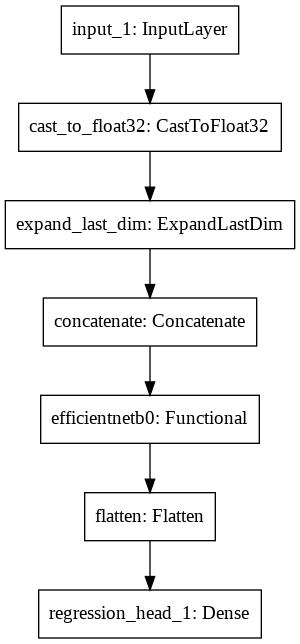

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(keras_model)

### Predicting some samples

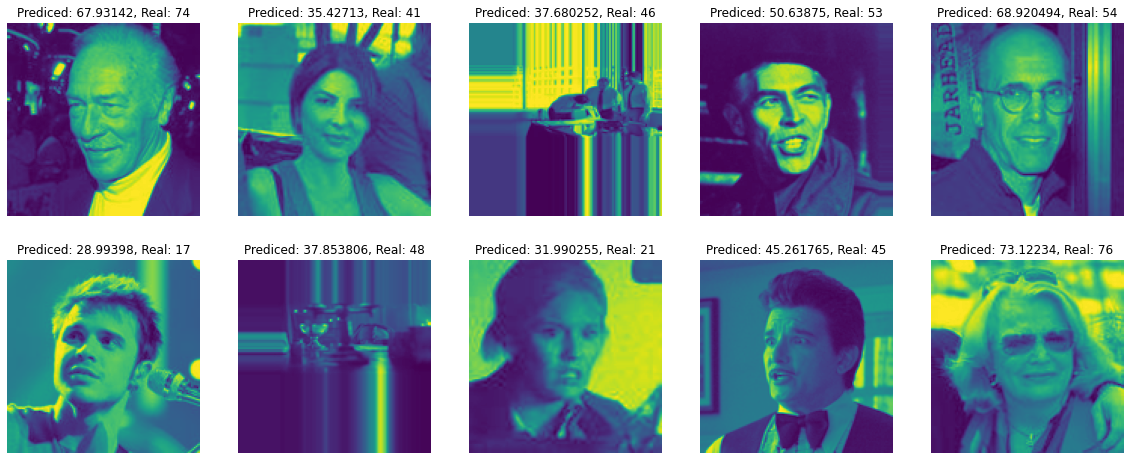

In [ ]:
predicted_y = keras_model.predict(test_imgs)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[20,8])
for i, v in enumerate(predicted_y[:10]):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_axis_off()
    ax.set_title('Prediced: %s, Real: %s' % (predicted_y[i][0], test_ages[i]))
    img = test_imgs[i]
    ax.imshow(img)
plt.show()